# Search image in the Dataset

With this notebook you can search for photos using natural language.

## Load the dataset

You will need the Unsplash Dataset and the precomputed feature vetors for this. You don't want to process the whole dataset yourself, you can download the preprocessed feature vectors from [here](https://drive.google.com/drive/folders/1ozUUr8UQ2YWDSJyYIIun9V8Qg1TjqXEs?usp=sharing).

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd

# Set the paths
dataset_version = "bso"  # choose "lite" or "full"
unsplash_dataset_path = Path
features_path = Path("unsplash-dataset") / dataset_version / "features"

# Read the photos table
#photos = pd.read_csv(unsplash_dataset_path / "photos.tsv000", sep='\t', header=0)

# Load the features and the corresponding IDs
photo_features = np.load(features_path / "features.npy")
photo_ids = pd.read_csv(features_path / "photo_ids.csv")
photo_ids = list(photo_ids['photo_id'])

Load the CLIP network.

In [3]:
import clip
import torch

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## Search

Specify your search query and encode it to a feature vector using CLIP.

In [25]:
search_query = "A mountain lake"

with torch.no_grad():
    # Encode and normalize the description using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

Compare the text features to the image features and find the best match.

In [26]:
# Retrieve the description vector and the photo vectors
text_features = text_encoded.cpu().numpy()

# Compute the similarity between the descrption and each photo using the Cosine similarity
similarities = list((text_features @ photo_features.T).squeeze(0))

# Sort the photos by their similarity score
best_photos = sorted(zip(similarities, range(photo_features.shape[0])), key=lambda x: x[0], reverse=True)

## Display the results

Show the top 3 results.

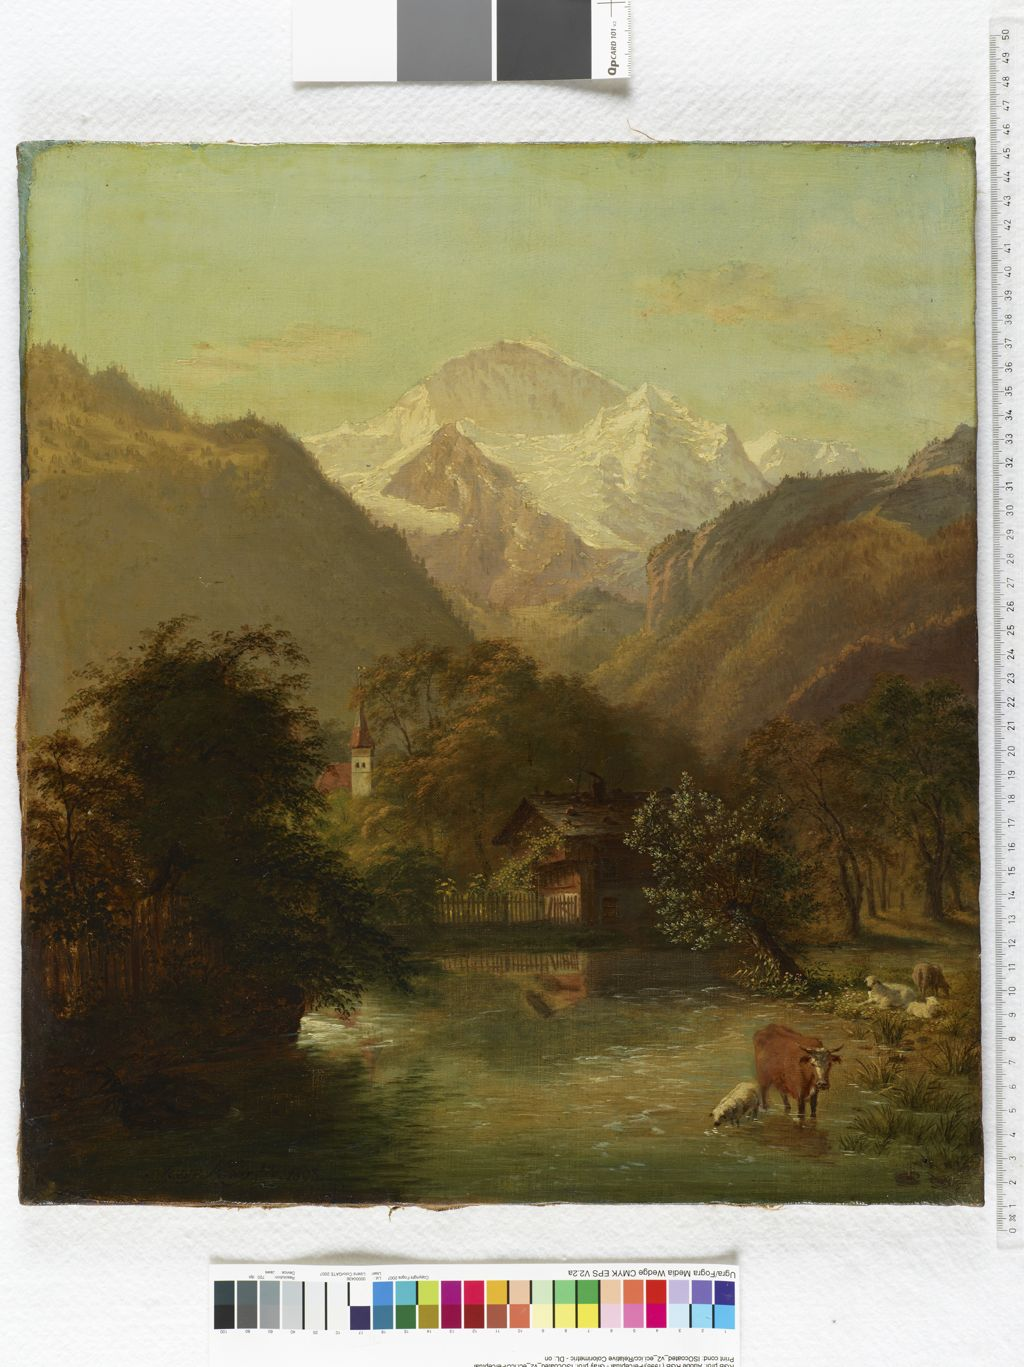

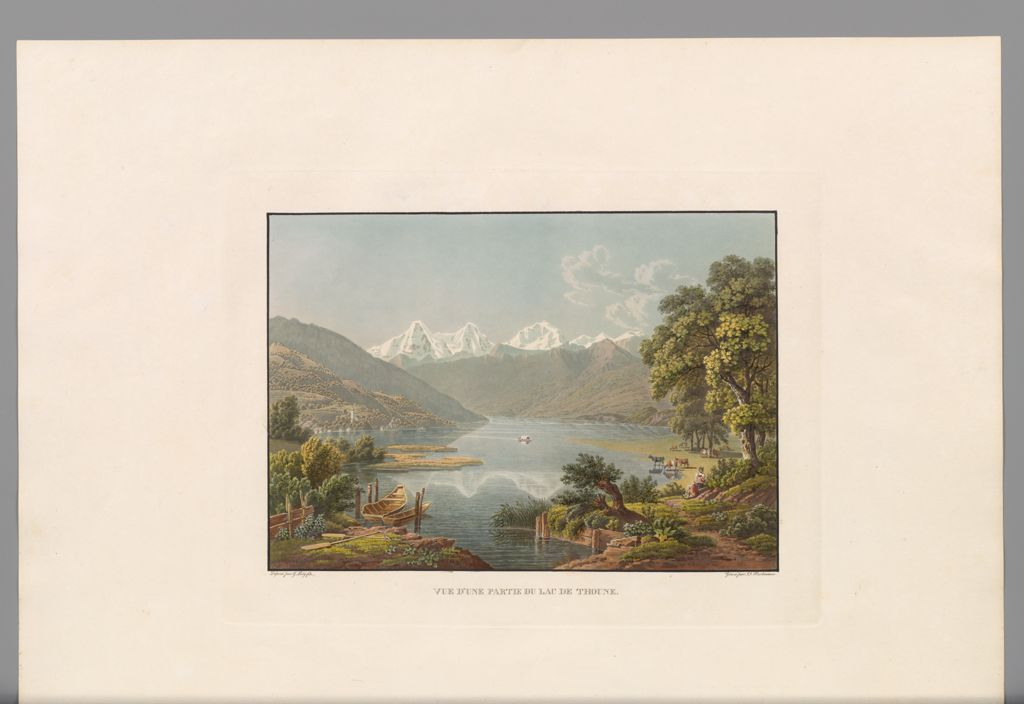

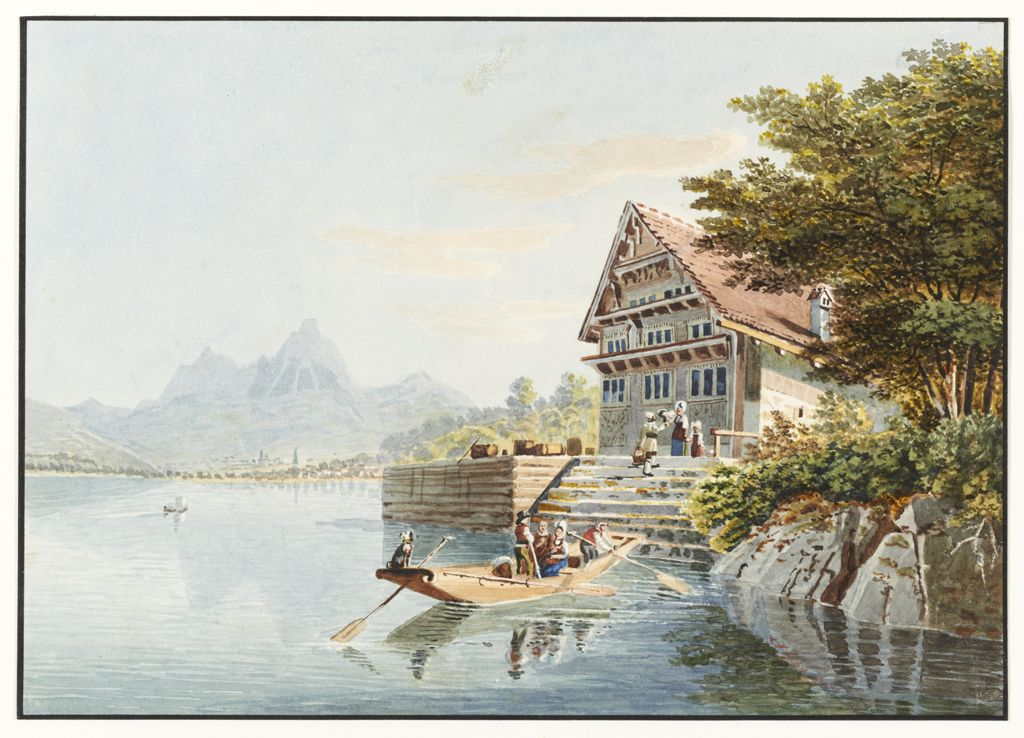

In [27]:
from IPython.display import Image
from IPython.core.display import HTML

# Iterate over the top 3 results
for i in range(3):
    # Retrieve the photo ID
    idx = best_photos[i][1]
    photo_id = photo_ids[idx]

    # Get all metadata for this photo
    #photo_data = photos[photos["photo_id"] == photo_id].iloc[0]

    # Display the photo
    display(Image("/home/cluster/fkraeu/data/bso-image-segmentation/data/images/" + photo_id + ".jpg"))

    # Display the attribution text
    #display(HTML(f'Photo by <a href="https://unsplash.com/@{photo_data["photographer_username"]}?utm_source=NaturalLanguageImageSearch&utm_medium=referral">{photo_data["photographer_first_name"]} {photo_data["photographer_last_name"]}</a> on <a href="https://unsplash.com/?utm_source=NaturalLanguageImageSearch&utm_medium=referral">Unsplash</a>'))
    print()
    